# Prediction of Maize rhizosphere microbiome in novel ecoystems

## Instructions to run the prediction:
### 1.- Run the first 3 cells in a row (using "Run" button on the top menu)
### 2.- Then, introduce the values you want for the environmental features (temperature, rain and plant age), using the sliders control
### 3.- Move to the next cell, and run the remaining 4-10 cells in a row ("Run" button), the same as in point 1, and see the graph with your predicted microbiome


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from ipywidgets import interact, widgets
import rpy2.rinterface

In [16]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
%reload_ext rpy2.ipython

In [17]:
a = widgets.FloatSlider(description='Temperature',min=40,max=100,value=60)
b = widgets.FloatSlider(description='Rain (3 days)',min=0,max=5,value=1.5)
c = widgets.IntSlider(description='Plant age',min=1,max=20,value=4)
t0 = widgets.Label(value=r'\(\textbf{'+'Introduce environmental features values'+'}\)')
t1 = widgets.Label(value="Please, select the environmental features associated to the maize plant/soil to") 
t2 = widgets.Label(value="what you would like to predict its rhizosphere microbiome:")
t = widgets.Label(value="(Units: temperature in ºF, rain in inches, plant age in weeks)")
ui = widgets.VBox([t0, t1, t2, t, a, b, c])

display(ui)

In [18]:
temp=a.value
rain=b.value
age=c.value
metadata = pd.DataFrame({'X.SampleID': ['new01'], 'age': [age], 'Temperature': [temp], 'Precipitation3Days':[rain]}, 
                  columns=['X.SampleID','age','Temperature','Precipitation3Days'])
metadata = metadata.set_index('X.SampleID')
domain = metadata[['age',
                   'Temperature',
                   'Precipitation3Days']]
domain

,age,Temperature,Precipitation3Days
X.SampleID,,,
new01,17,75.6,2.2


In [19]:
domain_novel_samples = domain.to_numpy(dtype=np.float32)

#### Load model

In [21]:
decoder = tf.keras.models.load_model('Models/decoder.h5', compile=False)
encoder_domain = tf.keras.models.load_model('Models/encoder_domain_model_latent.h5')

#### Compute new predictions

In [22]:
def save_predicted_otu_table(pred,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('abundances_'+suffix+'.tsv', index=True, header=True, sep='\t')  
    return df_otu

# Input only domain (i.e. environmental features)
pred_latent_novel_samples = encoder_domain.predict(domain_novel_samples)
pred_domain_novel_samples = decoder.predict(pred_latent_novel_samples)

# Get otu IDs
otu = pd.read_csv('otu_column_otuids.csv', index_col=0, header=None, sep='\t').T
otu = otu.set_index('otuids')
otuids = otu.columns

df_pred_otu = save_predicted_otu_table(pred_domain_novel_samples,domain.index,otuids,'predicted_otus_novel_features')

In [23]:
df_pred_otu

,4479944,513055,519510,810959,849092,1042671,818174,585221,1033380,875704,...,966091,55354,515709,902698,591499,569066,823091,219094,961783,823633
X.SampleID,,,,,,,,,,,,,,,,,,,,,
new01,0.000334,8.513715e-07,0.00123,0.000007,0.003613,0.000003,0.000275,0.000001,0.000001,0.000169,...,0.000266,0.000136,0.000149,0.001325,0.000249,0.002784,0.00027,2.229224e-07,0.08835,0.000021


#### Plot new predictions

In [24]:
%Rpush temp rain age

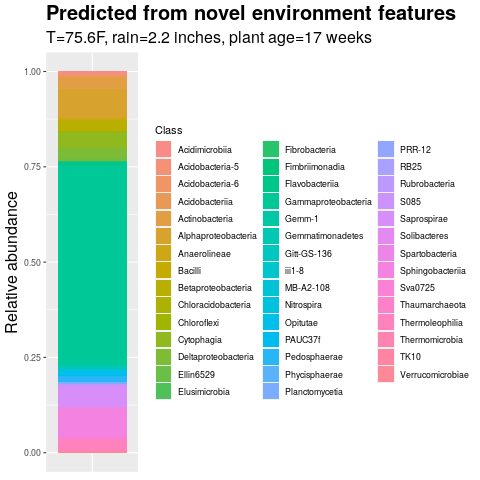

In [25]:
%%R
source('Src/functionsR_plotMicrobiome.r')
physeq_pred = build_physeq_object_otu_tax('abundances_predicted_otus_novel_features.tsv','tax_table_cleanNames.csv')
plot_taxa_agg(physeq_pred,"Class",temp,rain,age)